# 주의

**본 코드는 오픈소스가 아닙니다.** 따라서, 무단 배포 및 전재를 금합니다. 

- 본 코드 및 튜토리얼은 학습용으로만 사용해야 합니다.

자세한 사항은 테디노트(teddylee777@gmail.com) 에게 문의해 주시기 바랍니다.

In [1]:
# !pip install -qU langchain-teddynote

In [2]:
from dotenv import load_dotenv
from langchain_teddynote import logging

load_dotenv()
logging.langsmith("LangGraph-Parser")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Parser


## 노드 정의

필요한 API KEY
- OPENAI_API_KEY: 유료 키
- UPSTAGE_API_KEY: 유료 키 (https://console.upstage.ai/billing)


In [3]:
import os
from graphparser.state import GraphState
import graphparser.core as parser_core
import graphparser.pdf as pdf


# 문서 분할
split_pdf_node = pdf.SplitPDFFilesNode(batch_size=10)

# Layout Analyzer
layout_analyze_node = parser_core.LayoutAnalyzerNode(os.environ.get("UPSTAGE_API_KEY"))

# 페이지 요소 추출
page_element_extractor_node = parser_core.ExtractPageElementsNode()

# 이미지 자르기
image_cropper_node = parser_core.ImageCropperNode()

# 테이블 자르기
table_cropper_node = parser_core.TableCropperNode()

# 페이지별 텍스트 추출
extract_page_text = parser_core.ExtractPageTextNode()

# 페이지별 요약
page_summary_node = parser_core.CreatePageSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 이미지 요약
image_summary_node = parser_core.CreateImageSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 테이블 요약
table_summary_node = parser_core.CreateTableSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 테이블 Markdown 추출
table_markdown_extractor = parser_core.TableMarkdownExtractorNode()

## 그래프 정의

In [4]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# LangGraph을 생성
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("split_pdf_node", split_pdf_node)
workflow.add_node("layout_analyzer_node", layout_analyze_node)
workflow.add_node("page_element_extractor_node", page_element_extractor_node)
workflow.add_node("image_cropper_node", image_cropper_node)
workflow.add_node("table_cropper_node", table_cropper_node)
workflow.add_node("extract_page_text_node", extract_page_text)
workflow.add_node("page_summary_node", page_summary_node)
workflow.add_node("image_summary_node", image_summary_node)
workflow.add_node("table_summary_node", table_summary_node)
workflow.add_node("table_markdown_node", table_markdown_extractor)

# 각 노드들을 연결합니다.
workflow.add_edge("split_pdf_node", "layout_analyzer_node")
workflow.add_edge("layout_analyzer_node", "page_element_extractor_node")
workflow.add_edge("page_element_extractor_node", "image_cropper_node")
workflow.add_edge("page_element_extractor_node", "table_cropper_node")
workflow.add_edge("page_element_extractor_node", "extract_page_text_node")
workflow.add_edge("image_cropper_node", "page_summary_node")
workflow.add_edge("table_cropper_node", "page_summary_node")
workflow.add_edge("extract_page_text_node", "page_summary_node")
workflow.add_edge("page_summary_node", "image_summary_node")
workflow.add_edge("page_summary_node", "table_summary_node")
workflow.add_edge("image_summary_node", END)
workflow.add_edge("table_summary_node", "table_markdown_node")
workflow.add_edge("table_markdown_node", END)

workflow.set_entry_point("split_pdf_node")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

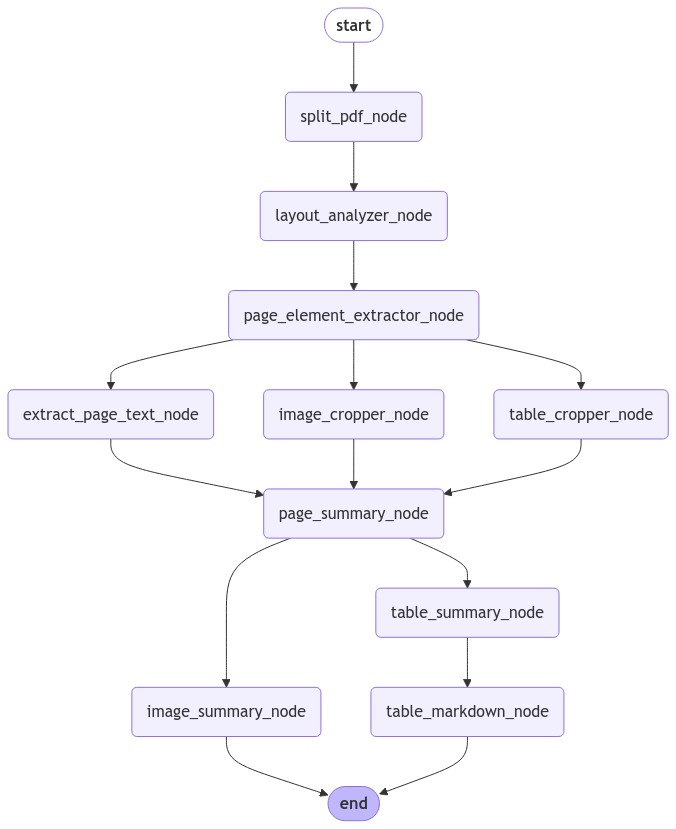

In [5]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

아래의 링크에서 데이터를 다운로드 받습니다.
- [샘플 데이터 링크](https://www.innovation.go.kr/ucms/bbs/B0000051/view.do?nttId=3801&menuNo=300145&searchType=&pageIndex=&searchType=)

In [6]:
### 설정 파라미터 ###
FILEPATH = "/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf"
LANGUAGE = "Korean"
### 설정 파라미터 ###

In [7]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=100, configurable={"thread_id": "TeddyNote-Parser"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(filepath=FILEPATH, language=LANGUAGE)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

총 페이지 수: 19
분할 PDF 생성: /Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획_0000_0009.pdf
분할 PDF 생성: /Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획_0010_0018.pdf
"Output from node 'split_pdf_node':"
'---'
{ 'split_filepaths': [ '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 '
                       '추진계획_0000_0009.pdf',
                       '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 '
                       '추진계획_0010_0018.pdf']}
'\n---\n'
"Output from node 'layout_analyzer_node':"
'---'
{ 'analyzed_files': [ '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 '
                      '추진계획_0000_0009.json',
                      '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 '
                      '추진계획_0010_0018.json']}
'\n---\n'
"Output from node 'page_element_extractor_node':"
'---'
{ 'page_elements': { 0: { 'elements': [ { 'bounding_box': [ { 'x': 201,
                                                              'y': 443},
       

In [8]:
state = app.get_state(config).values

## 저장 및 불러오기

In [9]:
from graphparser.layout_utils import save_state, load_state

# 상태 저장
# save_state(state, FILEPATH)

# 상태 불러오기
loaded_state = load_state(FILEPATH)
loaded_state

{'filepath': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf',
 'page_numbers': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18],
 'split_filepaths': ['/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획_0000_0009.pdf',
  '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획_0010_0018.pdf'],
 'analyzed_files': ['/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획_0000_0009.json',
  '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획_0010_0018.json'],
 'page_elements': {'0': {'image_elements': [],
   'table_elements': [],
   'text_elements': [{'bounding_box': [{'x': 201, 'y': 443},
      {'x': 984, 'y': 443},
      {'x': 984, 'y': 526},
      {'x': 201, 'y': 526}],
     'category': 'heading1',
     'html': "<h1 id='0' style='font-size:20px'>디지털 정부혁신 추진계획</h1>",
     'id': 0,
     'page': 0,
     'text': '디지털 정부혁신 추진계획'},
    {'bounding_box': [{'x': 450, 'y': 910},
      {'x': 726, 'y': 910}

In [10]:
state = loaded_state

## Markdown 생성

In [11]:
print(state["image_summary"]["79"])

<image>
<title>
디지털 정부혁신 추진전략
</title>
<summary>
이 문서는 디지털 정부혁신 추진전략에 대한 내용을 담고 있으며, 주요 목표는 정부 서비스의 디지털화 및 효율성 증대이다. 핵심 기술로는 AI, 빅데이터, 클라우드 컴퓨팅이 포함되며, 추진 기간은 2023년부터 2025년까지이다. 주요 성과 지표로는 서비스 이용자 수, 처리 속도 개선, 비용 절감이 있다.
</summary>
<entities> 
- 비전: 디지털로 여는 좋은 세상
- 추진 원칙: 최종 이용자의 관점, 공공서비스 수준 향상, 혁신적인 방법
- 우선 추진 과제: 대국민 서비스 혁신, 마이데이터 활성화, 시민참여 플랫폼 고도화
- 핵심 기술: AI, 빅데이터, 클라우드 컴퓨팅
- 추진 기간: 2023년 - 2025년
- 성과 지표: 서비스 이용자 수, 처리 속도 개선, 비용 절감
</entities>
<hypothetical_questions>
1. 디지털 정부혁신의 주요 목표는 무엇인가요?
2. 이 전략에서 강조하는 핵심 기술은 어떤 것들이 있나요?
3. 추진 기간은 언제부터 언제까지인가요?
4. 성과 지표로는 어떤 항목들이 포함되나요?
5. 시민참여 플랫폼 고도화의 중요성은 무엇인가요?
</hypothetical_questions>
</image>


In [12]:
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
import re


def extract_tag_content(content, tag):
    pattern = rf"<{tag}>(.*?)</{tag}>"
    match = re.search(pattern, content, re.DOTALL)

    if match:
        return match.group(1).strip()
    else:
        return None


def extract_non_tag_content(content, tag):
    pattern = rf"<{tag}>.*?</{tag}>"
    result = re.sub(pattern, "", content, flags=re.DOTALL)
    return result.strip()

### Image, Table 에서 추출된 데이터 Vector DB 생성을 위한 문서 생성

- Title, Summary, Entities 는 임베딩 검색에 걸리기 위한 문서로 생성
- hypothetical_questions 는 임베딩 검색에 걸리기 위한 문서로 생성

In [13]:
print(state["image_summary"]["79"])

<image>
<title>
디지털 정부혁신 추진전략
</title>
<summary>
이 문서는 디지털 정부혁신 추진전략에 대한 내용을 담고 있으며, 주요 목표는 정부 서비스의 디지털화 및 효율성 증대이다. 핵심 기술로는 AI, 빅데이터, 클라우드 컴퓨팅이 포함되며, 추진 기간은 2023년부터 2025년까지이다. 주요 성과 지표로는 서비스 이용자 수, 처리 속도 개선, 비용 절감이 있다.
</summary>
<entities> 
- 비전: 디지털로 여는 좋은 세상
- 추진 원칙: 최종 이용자의 관점, 공공서비스 수준 향상, 혁신적인 방법
- 우선 추진 과제: 대국민 서비스 혁신, 마이데이터 활성화, 시민참여 플랫폼 고도화
- 핵심 기술: AI, 빅데이터, 클라우드 컴퓨팅
- 추진 기간: 2023년 - 2025년
- 성과 지표: 서비스 이용자 수, 처리 속도 개선, 비용 절감
</entities>
<hypothetical_questions>
1. 디지털 정부혁신의 주요 목표는 무엇인가요?
2. 이 전략에서 강조하는 핵심 기술은 어떤 것들이 있나요?
3. 추진 기간은 언제부터 언제까지인가요?
4. 성과 지표로는 어떤 항목들이 포함되나요?
5. 시민참여 플랫폼 고도화의 중요성은 무엇인가요?
</hypothetical_questions>
</image>


In [14]:
print(state["table_summary"]["83"])

<table>
<title>
주요 과제별 추진일정 검토 및 확정
</title>
<summary>
이 표는 2019년부터 2022년까지의 주요 과제별 추진일정을 연도별로 정리한 것입니다. 각 부처의 반영이 필요하며, 추진일정은 사업계획 구체화 및 연차별 예산 확보 상황에 따라 변동 가능성이 있습니다.
</summary>
<entities> 
- 연도: 2019, 2020, 2021, 2022
- 추진일정: 상반기, 하반기
- 관계 부처: 각 부처
</entities>
<data_insights>
- 추진일정은 연도별로 상반기와 하반기로 나뉘어 있으며, 각 연도마다 일정이 다를 수 있음.
- 각 부처의 반영 필요성이 강조됨.
</data_insights>
<hypothetical_questions>
1. 각 연도별 추진일정의 주요 변경 사항은 무엇인가요?
2. 각 부처는 어떻게 추진일정을 반영하고 있나요?
3. 사업계획 구체화는 어떤 과정을 통해 이루어지나요?
4. 연차별 예산 확보 상황은 어떻게 평가되나요?
5. 추진일정 변동 가능성에 대한 구체적인 사례는 무엇인가요?
</hypothetical_questions>
</table>


In [15]:
print(extract_tag_content(state["image_summary"]["79"], "hypothetical_questions"))

1. 디지털 정부혁신의 주요 목표는 무엇인가요?
2. 이 전략에서 강조하는 핵심 기술은 어떤 것들이 있나요?
3. 추진 기간은 언제부터 언제까지인가요?
4. 성과 지표로는 어떤 항목들이 포함되나요?
5. 시민참여 플랫폼 고도화의 중요성은 무엇인가요?


In [16]:
print(extract_non_tag_content(state["image_summary"]["79"], "hypothetical_questions"))

<image>
<title>
디지털 정부혁신 추진전략
</title>
<summary>
이 문서는 디지털 정부혁신 추진전략에 대한 내용을 담고 있으며, 주요 목표는 정부 서비스의 디지털화 및 효율성 증대이다. 핵심 기술로는 AI, 빅데이터, 클라우드 컴퓨팅이 포함되며, 추진 기간은 2023년부터 2025년까지이다. 주요 성과 지표로는 서비스 이용자 수, 처리 속도 개선, 비용 절감이 있다.
</summary>
<entities> 
- 비전: 디지털로 여는 좋은 세상
- 추진 원칙: 최종 이용자의 관점, 공공서비스 수준 향상, 혁신적인 방법
- 우선 추진 과제: 대국민 서비스 혁신, 마이데이터 활성화, 시민참여 플랫폼 고도화
- 핵심 기술: AI, 빅데이터, 클라우드 컴퓨팅
- 추진 기간: 2023년 - 2025년
- 성과 지표: 서비스 이용자 수, 처리 속도 개선, 비용 절감
</entities>

</image>


### Table

In [17]:
state["table_summary"]

{'83': '<table>\n<title>\n주요 과제별 추진일정 검토 및 확정\n</title>\n<summary>\n이 표는 2019년부터 2022년까지의 주요 과제별 추진일정을 연도별로 정리한 것입니다. 각 부처의 반영이 필요하며, 추진일정은 사업계획 구체화 및 연차별 예산 확보 상황에 따라 변동 가능성이 있습니다.\n</summary>\n<entities> \n- 연도: 2019, 2020, 2021, 2022\n- 추진일정: 상반기, 하반기\n- 관계 부처: 각 부처\n</entities>\n<data_insights>\n- 추진일정은 연도별로 상반기와 하반기로 나뉘어 있으며, 각 연도마다 일정이 다를 수 있음.\n- 각 부처의 반영 필요성이 강조됨.\n</data_insights>\n<hypothetical_questions>\n1. 각 연도별 추진일정의 주요 변경 사항은 무엇인가요?\n2. 각 부처는 어떻게 추진일정을 반영하고 있나요?\n3. 사업계획 구체화는 어떤 과정을 통해 이루어지나요?\n4. 연차별 예산 확보 상황은 어떻게 평가되나요?\n5. 추진일정 변동 가능성에 대한 구체적인 사례는 무엇인가요?\n</hypothetical_questions>\n</table>',
 '84': "<table>\n<title>\n주요 과제별 추진 일정 검토 및 확정\n</title>\n<summary>\n이 표는 각 부처의 주요 과제별 추진 일정과 관련된 내용을 정리한 것으로, 과제별로 추진 일정이 사업계획 구체화 및 연차별 예산 확보 상황에 따라 변동 가능함을 나타냅니다.\n</summary>\n<entities> \n- 과제: 선제적 통합적 대국민 서비스 혁신, 공공부문 마이데이터 활성화, 시민 참여를 위한 플랫폼 고도화, 현장중심 협업 지원 스마트 업무환경 구축, 클라우드 및 디지털 서비스 이용 활성화, 개방형 데이터·서비스 생태계 구축\n- 부처: 행안부, 과기정통부, 각 부처\n</entities>\n<data_insights>\n- 각 과제는 

In [18]:
# XML 파싱을 위해 import 문을 추가합니다
import xml.etree.ElementTree as ET


def convert_to_markdown_table(table_summary):
    html = "<table>\n"

    # table_summary가 문자열인 경우를 처리합니다
    if isinstance(table_summary, str):
        # XML 파싱을 사용하여 문자열에서 데이터를 추출합니다
        root = ET.fromstring(table_summary)
        for child in root:
            html += f"  <tr>\n    <th>{child.tag}</th>\n    <td>"

            if child.tag in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in child.text.strip().split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif child.tag == "hypothetical_questions":
                html += "<ol>\n"
                for item in child.text.strip().split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += child.text.strip()

            html += "</td>\n  </tr>\n"
    else:
        # 기존의 딕셔너리 처리 로직을 유지합니다
        for key, value in table_summary.items():
            html += f"  <tr>\n    <th>{key}</th>\n    <td>"

            if key in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in value.split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif key == "hypothetical_questions":
                html += "<ol>\n"
                for item in value.split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += value

            html += "</td>\n  </tr>\n"

    html += "</table>"
    return html

In [19]:
print(state["table_summary"]["83"])

<table>
<title>
주요 과제별 추진일정 검토 및 확정
</title>
<summary>
이 표는 2019년부터 2022년까지의 주요 과제별 추진일정을 연도별로 정리한 것입니다. 각 부처의 반영이 필요하며, 추진일정은 사업계획 구체화 및 연차별 예산 확보 상황에 따라 변동 가능성이 있습니다.
</summary>
<entities> 
- 연도: 2019, 2020, 2021, 2022
- 추진일정: 상반기, 하반기
- 관계 부처: 각 부처
</entities>
<data_insights>
- 추진일정은 연도별로 상반기와 하반기로 나뉘어 있으며, 각 연도마다 일정이 다를 수 있음.
- 각 부처의 반영 필요성이 강조됨.
</data_insights>
<hypothetical_questions>
1. 각 연도별 추진일정의 주요 변경 사항은 무엇인가요?
2. 각 부처는 어떻게 추진일정을 반영하고 있나요?
3. 사업계획 구체화는 어떤 과정을 통해 이루어지나요?
4. 연차별 예산 확보 상황은 어떻게 평가되나요?
5. 추진일정 변동 가능성에 대한 구체적인 사례는 무엇인가요?
</hypothetical_questions>
</table>


In [20]:
markdown_table = convert_to_markdown_table(state["table_summary"]["83"])
print(markdown_table)

<table>
  <tr>
    <th>title</th>
    <td>주요 과제별 추진일정 검토 및 확정</td>
  </tr>
  <tr>
    <th>summary</th>
    <td>이 표는 2019년부터 2022년까지의 주요 과제별 추진일정을 연도별로 정리한 것입니다. 각 부처의 반영이 필요하며, 추진일정은 사업계획 구체화 및 연차별 예산 확보 상황에 따라 변동 가능성이 있습니다.</td>
  </tr>
  <tr>
    <th>entities</th>
    <td><ul>
      <li>- 연도: 2019, 2020, 2021, 2022</li>
      <li>추진일정: 상반기, 하반기</li>
      <li>관계 부처: 각 부처</li>
    </ul></td>
  </tr>
  <tr>
    <th>data_insights</th>
    <td><ul>
      <li>- 추진일정은 연도별로 상반기와 하반기로 나뉘어 있으며, 각 연도마다 일정이 다를 수 있음.</li>
      <li>각 부처의 반영 필요성이 강조됨.</li>
    </ul></td>
  </tr>
  <tr>
    <th>hypothetical_questions</th>
    <td><ol>
      <li>1. 각 연도별 추진일정의 주요 변경 사항은 무엇인가요?</li>
      <li>2. 각 부처는 어떻게 추진일정을 반영하고 있나요?</li>
      <li>3. 사업계획 구체화는 어떤 과정을 통해 이루어지나요?</li>
      <li>4. 연차별 예산 확보 상황은 어떻게 평가되나요?</li>
      <li>5. 추진일정 변동 가능성에 대한 구체적인 사례는 무엇인가요?</li>
    </ol></td>
  </tr>
</table>


In [21]:
def create_document(content, metadata):
    """
    문서 객체를 생성합니다.

    Args:
        content (str): 문서의 내용
        metadata (dict): 문서의 메타데이터

    Returns:
        Document: 생성된 문서 객체
    """
    return Document(page_content=content, metadata=metadata)


def process_image_element(element, state, page_number):
    """
    이미지 요소를 처리합니다.

    Args:
        element (dict): 이미지 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체 리스트
    """
    image_id = str(element["id"])
    image_summary = state["image_summary"][image_id]
    image_path = state["images"][image_id]
    image_path_md = f"![{image_path}]({image_path})"

    image_summary_md = convert_to_markdown_table(image_summary)
    markdown = f"{image_path_md}"

    image_summary_clean = extract_non_tag_content(
        image_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            image_summary_clean,
            {
                "type": "image",
                "image": image_path,
                "page": page_number,
                "source": state["filepath"],
                "id": image_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        image_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "image": image_path,
                    "summary": image_summary_clean,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": image_id,
                },
            )
        )

    return markdown, docs, hypo_docs


def process_table_element(element, state, page_number):
    """
    테이블 요소를 처리합니다.

    Args:
        element (dict): 테이블 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체
    """
    table_id = str(element["id"])
    table_summary = state["table_summary"][table_id]
    table_markdown = state["table_markdown"][table_id]
    table_path = state["tables"][table_id]
    table_path_md = f"![{table_path}]({table_path})"

    table_summary_md = convert_to_markdown_table(table_summary)
    markdown = f"{table_path_md}\n{table_markdown}"

    table_summary_clean = extract_non_tag_content(
        table_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            table_summary_clean,
            {
                "type": "table",
                "table": table_path,
                "markdown": table_markdown,
                "page": page_number,
                "source": state["filepath"],
                "id": table_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        table_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "table": table_path,
                    "summary": table_summary_clean,
                    "markdown": table_markdown,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": table_id,
                },
            )
        )

    return markdown, docs, hypo_docs


def process_text_element(element):
    """
    텍스트 요소를 처리합니다.

    Args:
        element (dict): 텍스트 요소 정보

    Returns:
        str: 텍스트 내용
    """
    return element["text"]


def process_page(page, state, page_number, text_splitter):
    """
    페이지를 처리합니다.

    Args:
        page (dict): 페이지 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호
        text_splitter (RecursiveCharacterTextSplitter): 텍스트 분할기

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    page_texts = []

    for element in page["elements"]:
        if element["category"] == "figure":
            markdown, element_docs, hypo_doc = process_image_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        elif element["category"] == "table":
            markdown, element_docs, hypo_doc = process_table_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        else:
            text = process_text_element(element)
            markdowns.append(text)
            page_texts.append(text)

    page_text = "\n".join(page_texts)
    split_texts = text_splitter.split_text(page_text)

    text_summary = state["text_summary"][str(page_number)]
    docs.append(
        create_document(
            text_summary,
            metadata={
                "type": "page_summary",
                "page": page_number,
                "source": state["filepath"],
                "text": page_text,
            },
        )
    )

    for text in split_texts:
        docs.append(
            create_document(
                text,
                metadata={
                    "type": "text",
                    "page": page_number,
                    "source": state["filepath"],
                    "summary": text_summary,
                },
            )
        )

    return markdowns, docs, hypo_docs


def process_document(state):
    """
    전체 문서를 처리합니다.

    Args:
        state (dict): 현재 상태

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

    for page_number, page in state["page_elements"].items():
        page_markdowns, page_docs, page_hypo_docs = process_page(
            page, state, page_number, text_splitter
        )
        markdowns.extend(page_markdowns)
        docs.extend(page_docs)
        hypo_docs.extend(page_hypo_docs)

    return markdowns, docs, hypo_docs


markdowns, docs, hypo_docs = process_document(state)

In [22]:
# Markdown 파일로 텍스트 저장
with open(FILEPATH.replace(".pdf", ".md"), "w", encoding="utf-8") as f:
    f.write("\n\n".join(markdowns))

print(f"텍스트가 '{FILEPATH.replace('.pdf', '.md')}' 파일로 저장되었습니다.")

텍스트가 '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.md' 파일로 저장되었습니다.


In [23]:
len(docs)

75

In [24]:
docs

[Document(metadata={'type': 'page_summary', 'page': '0', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf', 'text': '디지털 정부혁신 추진계획\n2019. 10. 29.\n관계부처 합동'}, page_content='- 디지털 정부혁신 추진계획 발표일: 2019년 10월 29일\n- 주체: 관계부처 합동\n- 목적: 디지털 정부 혁신 추진'),
 Document(metadata={'type': 'text', 'page': '0', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf', 'summary': '- 디지털 정부혁신 추진계획 발표일: 2019년 10월 29일\n- 주체: 관계부처 합동\n- 목적: 디지털 정부 혁신 추진'}, page_content='디지털 정부혁신 추진계획\n2019. 10. 29.\n관계부처 합동'),
 Document(metadata={'type': 'page_summary', 'page': '1', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf', 'text': '순 서\nⅠ. 개요 ······························································· 1\nⅡ. 디지털 정부혁신 추진계획 ······················· 2\n1. 우선 추진과제 ································································ 2\n① 선제적·통합적 대국민 서비스 혁신\n② 공공부문 마이데이터 활성화\n③ 시민참여를 위한 플랫폼 고도화\n④ 현장중심 협업을 지원하는 스마트 업무환경 구현\n⑤ 클라우드와 디지털서비스 이용 활성화\n⑥ 개방형 데이터·

In [25]:
hypo_docs

[Document(metadata={'type': 'hypothetical_questions', 'image': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획/79.png', 'summary': '<image>\n<title>\n디지털 정부혁신 추진전략\n</title>\n<summary>\n이 문서는 디지털 정부혁신 추진전략에 대한 내용을 담고 있으며, 주요 목표는 정부 서비스의 디지털화 및 효율성 증대이다. 핵심 기술로는 AI, 빅데이터, 클라우드 컴퓨팅이 포함되며, 추진 기간은 2023년부터 2025년까지이다. 주요 성과 지표로는 서비스 이용자 수, 처리 속도 개선, 비용 절감이 있다.\n</summary>\n<entities> \n- 비전: 디지털로 여는 좋은 세상\n- 추진 원칙: 최종 이용자의 관점, 공공서비스 수준 향상, 혁신적인 방법\n- 우선 추진 과제: 대국민 서비스 혁신, 마이데이터 활성화, 시민참여 플랫폼 고도화\n- 핵심 기술: AI, 빅데이터, 클라우드 컴퓨팅\n- 추진 기간: 2023년 - 2025년\n- 성과 지표: 서비스 이용자 수, 처리 속도 개선, 비용 절감\n</entities>\n\n</image>', 'page': '6', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf', 'id': '79'}, page_content='1. 디지털 정부혁신의 주요 목표는 무엇인가요?\n2. 이 전략에서 강조하는 핵심 기술은 어떤 것들이 있나요?\n3. 추진 기간은 언제부터 언제까지인가요?\n4. 성과 지표로는 어떤 항목들이 포함되나요?\n5. 시민참여 플랫폼 고도화의 중요성은 무엇인가요?'),
 Document(metadata={'type': 'hypothetical_questions', 'table': '/Users/teddy/Dev/github/teddynote-parser/data/디지털

In [26]:
len(hypo_docs)

10

In [27]:
docs[12].__dict__

{'id': None,
 'metadata': {'type': 'page_summary',
  'page': '4',
  'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf',
  'text': '○ (전자증명서) 스마트폰(전자지갑)을 활용해 각종 증명서를 전자적\n으로 발급‧보관하고, 관공서‧은행 등에 방문 없이 제출\n* (19년) 주민등록등·초본 → (20년) 가족관계증명서 등 100종 → (21년) 인감증명서 등 300종\n○ (모바일 신분증) 위‧변조 및 도용우려가 있는 기존 플라스틱 카드\n보다 안정성‧편의성이 높은 스마트폰 기반 디지털 신분증 도입\n* 학생증, 공무원증 등 이용대상과 목적이 명확한 분야부터 안전성 점검 후 단계적 확대\n○ (디지털 고지‧수납) 각종 고지서·안내문* 등을 온라인(공공‧민간)\n으로 받고, 간편하게 납부할 수 있도록 디지털 고지‧수납 활성화\n* 종이고지서 건수(‘18년 천만건) : 국세 1.1, 지방세 19.5, 4대보험 12.5, 자동차검사안내 2.3\n3\n시민 참여를 위한 플랫폼 고도화\n○ (국민의 소리) 개별 운영중인 콜센터(118개 기관, 156개 콜센터) 시스템을\n통합하여, 접수부터 완결까지 단절없는 상담내역 관리‧분석체계 구축\n* (기존) 신문고 등 문자민원 분석 → (개선) 신문고 + 전화상담 데이터 통합 분석\n○ (도전.한국) 일반적 공모전과 차별화*한 가칭도전.한국 플랫폼을\n운영하여 사회문제 해결을 위한 시민참여의 장 제공\n* 도전적 문제 제시(현장공무원+전문가 참여), 과감한 포상과 후속 지원, 확실한 정책 반영\n○ (취약계층 지원) 디지털 취약계층의 오프라인 수수료 감면* 및 비대면\n서비스 확산(키오스크 등)에 대응한 실생활중심 콘텐츠 개발‧보급\n* 주민등록등본 발급의 경우, 온라인은 무료, 주민센터 발급은 400원의 수수료 부과\n현장중심 협업을 지원하는 스마트 업무환경 구현\n4\n○ (스마트 

In [28]:
for i, d in enumerate(docs):
    print(i, d.metadata["type"])

0 page_summary
1 text
2 page_summary
3 text
4 page_summary
5 text
6 text
7 text
8 page_summary
9 text
10 text
11 text
12 page_summary
13 text
14 text
15 text
16 page_summary
17 text
18 text
19 text
20 image
21 page_summary
22 text
23 table
24 table
25 page_summary
26 text
27 page_summary
28 text
29 text
30 text
31 page_summary
32 text
33 text
34 text
35 image
36 table
37 page_summary
38 text
39 text
40 page_summary
41 text
42 text
43 text
44 table
45 table
46 page_summary
47 text
48 text
49 text
50 page_summary
51 text
52 text
53 text
54 table
55 page_summary
56 text
57 text
58 text
59 table
60 page_summary
61 text
62 text
63 table
64 page_summary
65 text
66 text
67 text
68 page_summary
69 text
70 text
71 text
72 page_summary
73 text
74 text


In [29]:
docs[3].__dict__

{'id': None,
 'metadata': {'type': 'text',
  'page': '1',
  'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf',
  'summary': '- 개요: 문서의 구조 및 내용 소개\n- 디지털 정부혁신 추진계획:\n  - 우선 추진과제:\n    1. 선제적·통합적 대국민 서비스 혁신\n    2. 공공부문 마이데이터 활성화\n    3. 시민참여를 위한 플랫폼 고도화\n    4. 현장중심 협업을 지원하는 스마트 업무환경 구현\n    5. 클라우드와 디지털서비스 이용 활성화\n    6. 개방형 데이터·서비스 생태계 구축\n  - 중장기 범정부 디지털 전환 로드맵 수립\n- 추진체계 및 일정: 4페이지에 상세 내용 포함\n- [붙임]: 디지털 정부혁신 우선 추진과제(상세) 8페이지'},
 'page_content': '순 서\nⅠ. 개요 ······························································· 1\nⅡ. 디지털 정부혁신 추진계획 ······················· 2\n1. 우선 추진과제 ································································ 2\n① 선제적·통합적 대국민 서비스 혁신\n② 공공부문 마이데이터 활성화\n③ 시민참여를 위한 플랫폼 고도화\n④ 현장중심 협업을 지원하는 스마트 업무환경 구현\n⑤ 클라우드와 디지털서비스 이용 활성화\n⑥ 개방형 데이터·서비스 생태계 구축\n2. 중장기 범정부 디지털 전환 로드맵 수립 ················ 4\nⅢ. 추진체계 및 일정 ······································· 4\n[붙임] 디지털 정부혁신 우선 추진과제(상세) ··········· 8',
 'type': 'Document'}

In [30]:
docs[20].__dict__

{'id': None,
 'metadata': {'type': 'image',
  'image': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획/79.png',
  'page': '6',
  'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf',
  'id': '79'},
 'page_content': '<image>\n<title>\n디지털 정부혁신 추진전략\n</title>\n<summary>\n이 문서는 디지털 정부혁신 추진전략에 대한 내용을 담고 있으며, 주요 목표는 정부 서비스의 디지털화 및 효율성 증대이다. 핵심 기술로는 AI, 빅데이터, 클라우드 컴퓨팅이 포함되며, 추진 기간은 2023년부터 2025년까지이다. 주요 성과 지표로는 서비스 이용자 수, 처리 속도 개선, 비용 절감이 있다.\n</summary>\n<entities> \n- 비전: 디지털로 여는 좋은 세상\n- 추진 원칙: 최종 이용자의 관점, 공공서비스 수준 향상, 혁신적인 방법\n- 우선 추진 과제: 대국민 서비스 혁신, 마이데이터 활성화, 시민참여 플랫폼 고도화\n- 핵심 기술: AI, 빅데이터, 클라우드 컴퓨팅\n- 추진 기간: 2023년 - 2025년\n- 성과 지표: 서비스 이용자 수, 처리 속도 개선, 비용 절감\n</entities>\n\n</image>',
 'type': 'Document'}

In [31]:
docs[23].__dict__

{'id': None,
 'metadata': {'type': 'table',
  'table': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획/83.png',
  'markdown': '| 추진일정 | 2019 | 2020 | 2021 | 2022 | 관계부처 |\n|----------|------|------|------|------|----------|\n|          | 상   | 하   | 상   | 하   |          |',
  'page': '7',
  'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf',
  'id': '83'},
 'page_content': '<table>\n<title>\n주요 과제별 추진일정 검토 및 확정\n</title>\n<summary>\n이 표는 2019년부터 2022년까지의 주요 과제별 추진일정을 연도별로 정리한 것입니다. 각 부처의 반영이 필요하며, 추진일정은 사업계획 구체화 및 연차별 예산 확보 상황에 따라 변동 가능성이 있습니다.\n</summary>\n<entities> \n- 연도: 2019, 2020, 2021, 2022\n- 추진일정: 상반기, 하반기\n- 관계 부처: 각 부처\n</entities>\n<data_insights>\n- 추진일정은 연도별로 상반기와 하반기로 나뉘어 있으며, 각 연도마다 일정이 다를 수 있음.\n- 각 부처의 반영 필요성이 강조됨.\n</data_insights>\n\n</table>',
 'type': 'Document'}

In [32]:
hypo_docs[0].__dict__

{'id': None,
 'metadata': {'type': 'hypothetical_questions',
  'image': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획/79.png',
  'summary': '<image>\n<title>\n디지털 정부혁신 추진전략\n</title>\n<summary>\n이 문서는 디지털 정부혁신 추진전략에 대한 내용을 담고 있으며, 주요 목표는 정부 서비스의 디지털화 및 효율성 증대이다. 핵심 기술로는 AI, 빅데이터, 클라우드 컴퓨팅이 포함되며, 추진 기간은 2023년부터 2025년까지이다. 주요 성과 지표로는 서비스 이용자 수, 처리 속도 개선, 비용 절감이 있다.\n</summary>\n<entities> \n- 비전: 디지털로 여는 좋은 세상\n- 추진 원칙: 최종 이용자의 관점, 공공서비스 수준 향상, 혁신적인 방법\n- 우선 추진 과제: 대국민 서비스 혁신, 마이데이터 활성화, 시민참여 플랫폼 고도화\n- 핵심 기술: AI, 빅데이터, 클라우드 컴퓨팅\n- 추진 기간: 2023년 - 2025년\n- 성과 지표: 서비스 이용자 수, 처리 속도 개선, 비용 절감\n</entities>\n\n</image>',
  'page': '6',
  'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf',
  'id': '79'},
 'page_content': '1. 디지털 정부혁신의 주요 목표는 무엇인가요?\n2. 이 전략에서 강조하는 핵심 기술은 어떤 것들이 있나요?\n3. 추진 기간은 언제부터 언제까지인가요?\n4. 성과 지표로는 어떤 항목들이 포함되나요?\n5. 시민참여 플랫폼 고도화의 중요성은 무엇인가요?',
 'type': 'Document'}

In [33]:
hypo_docs[2].__dict__

{'id': None,
 'metadata': {'type': 'hypothetical_questions',
  'table': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획/84.png',
  'summary': "<table>\n<title>\n주요 과제별 추진 일정 검토 및 확정\n</title>\n<summary>\n이 표는 각 부처의 주요 과제별 추진 일정과 관련된 내용을 정리한 것으로, 과제별로 추진 일정이 사업계획 구체화 및 연차별 예산 확보 상황에 따라 변동 가능함을 나타냅니다.\n</summary>\n<entities> \n- 과제: 선제적 통합적 대국민 서비스 혁신, 공공부문 마이데이터 활성화, 시민 참여를 위한 플랫폼 고도화, 현장중심 협업 지원 스마트 업무환경 구축, 클라우드 및 디지털 서비스 이용 활성화, 개방형 데이터·서비스 생태계 구축\n- 부처: 행안부, 과기정통부, 각 부처\n</entities>\n<data_insights>\n- 각 과제는 특정 부처에 의해 추진되며, 예산 확보와 사업계획에 따라 일정이 조정될 수 있음.\n- 예를 들어, '선제적 통합적 대국민 서비스 혁신' 과제는 2차, 4차, 7차, 10차로 나뉘어 진행됨.\n</data_insights>\n\n</table>",
  'markdown': '| 번호 | 항목 | 세부 내용 | 담당 부서 | 비고 |\n|------|------|-----------|------------|------|\n| 1    | 선제적·통합적 대국민 서비스 혁신 | 1. 대국민 편익서비스 맞춤형 안내 | 보조금ISP | 행안부, 각부처 |\n|      |      | 2. 생애주기 서비스 대폭 확대 | 2개 | 4개 | 7개 | 10개 |\n|      |      | 3. 사각지대 예방을 위한 선제적 서비스 제공 | 마스플랜팀 | 지자체 |\n|      |      | 4. 기존 한계를 뛰어넘는 공공서비스 혁신사업 추진

In [34]:
docs

[Document(metadata={'type': 'page_summary', 'page': '0', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf', 'text': '디지털 정부혁신 추진계획\n2019. 10. 29.\n관계부처 합동'}, page_content='- 디지털 정부혁신 추진계획 발표일: 2019년 10월 29일\n- 주체: 관계부처 합동\n- 목적: 디지털 정부 혁신 추진'),
 Document(metadata={'type': 'text', 'page': '0', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf', 'summary': '- 디지털 정부혁신 추진계획 발표일: 2019년 10월 29일\n- 주체: 관계부처 합동\n- 목적: 디지털 정부 혁신 추진'}, page_content='디지털 정부혁신 추진계획\n2019. 10. 29.\n관계부처 합동'),
 Document(metadata={'type': 'page_summary', 'page': '1', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf', 'text': '순 서\nⅠ. 개요 ······························································· 1\nⅡ. 디지털 정부혁신 추진계획 ······················· 2\n1. 우선 추진과제 ································································ 2\n① 선제적·통합적 대국민 서비스 혁신\n② 공공부문 마이데이터 활성화\n③ 시민참여를 위한 플랫폼 고도화\n④ 현장중심 협업을 지원하는 스마트 업무환경 구현\n⑤ 클라우드와 디지털서비스 이용 활성화\n⑥ 개방형 데이터·

## RAG 예제

In [35]:
# !pip install -qU rank_bm25 faiss-cpu langchain-community==0.2.14 langchain-teddynote

문서 범위 설정

In [36]:
all_docs = docs + hypo_docs
len(all_docs)

85

Retriever 생성

In [37]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

# bm25 retriever와 faiss retriever를 초기화합니다.
bm25_retriever = BM25Retriever.from_documents(
    all_docs,
)
bm25_retriever.k = 5  # BM25Retriever의 검색 결과 개수를 1로 설정합니다.

embedding = OpenAIEmbeddings()  # OpenAI 임베딩을 사용합니다.

faiss_vectorstore = FAISS.from_documents(
    all_docs,
    embedding,
)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 5})

# 앙상블 retriever를 초기화합니다.
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.7, 0.3],
)

Relevance Checker 로직을 활용한 중요 정보 필터링

In [38]:
from langchain_teddynote.evaluator import OpenAIRelevanceGrader
from langchain_openai import ChatOpenAI

# teddynote Groundness Checker 생성
groundedness_check = OpenAIRelevanceGrader(
    ChatOpenAI(model="gpt-4o-mini", temperature=0), target="retrieval-question"
).create()

In [39]:
retrieved_documents = ensemble_retriever.invoke(
    "디지털 정부혁신의 주요 목표는 무엇인가요?"
)
retrieved_documents

[Document(metadata={'type': 'hypothetical_questions', 'image': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획/79.png', 'summary': '<image>\n<title>\n디지털 정부혁신 추진전략\n</title>\n<summary>\n이 문서는 디지털 정부혁신 추진전략에 대한 내용을 담고 있으며, 주요 목표는 정부 서비스의 디지털화 및 효율성 증대이다. 핵심 기술로는 AI, 빅데이터, 클라우드 컴퓨팅이 포함되며, 추진 기간은 2023년부터 2025년까지이다. 주요 성과 지표로는 서비스 이용자 수, 처리 속도 개선, 비용 절감이 있다.\n</summary>\n<entities> \n- 비전: 디지털로 여는 좋은 세상\n- 추진 원칙: 최종 이용자의 관점, 공공서비스 수준 향상, 혁신적인 방법\n- 우선 추진 과제: 대국민 서비스 혁신, 마이데이터 활성화, 시민참여 플랫폼 고도화\n- 핵심 기술: AI, 빅데이터, 클라우드 컴퓨팅\n- 추진 기간: 2023년 - 2025년\n- 성과 지표: 서비스 이용자 수, 처리 속도 개선, 비용 절감\n</entities>\n\n</image>', 'page': '6', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf', 'id': '79'}, page_content='1. 디지털 정부혁신의 주요 목표는 무엇인가요?\n2. 이 전략에서 강조하는 핵심 기술은 어떤 것들이 있나요?\n3. 추진 기간은 언제부터 언제까지인가요?\n4. 성과 지표로는 어떤 항목들이 포함되나요?\n5. 시민참여 플랫폼 고도화의 중요성은 무엇인가요?'),
 Document(metadata={'type': 'hypothetical_questions', 'table': '/Users/teddy/Dev/github/teddynote-parser/data/디지털

In [40]:
def clean_retrieved_documents(retrieved_documents):
    clean_docs = []

    for doc in retrieved_documents:
        metadata = doc.metadata
        new_metadata = {}
        content = doc.page_content

        # 문서 타입이 'page_summary' 또는 'text'인 경우
        if metadata["type"] in ["page_summary", "text"]:
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 'text' 타입인 경우 요약 정보도 추가
            if metadata["type"] == "text":
                # content += f'\n\n<summary>{metadata["summary"]}</summary>'
                new_metadata["summary"] = metadata["summary"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'image'인 경우
        elif metadata["type"] == "image":
            image_path = metadata["image"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환
            content = convert_to_markdown_table(content)

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'table'인 경우
        elif metadata["type"] == "table":
            table_path = metadata["table"]
            table_markdown = metadata["markdown"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환하고 원본 마크다운과 결합
            content = f"{convert_to_markdown_table(content)}\n\n{table_markdown}"

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'hypothetical_questions'인 경우
        elif metadata["type"] == "hypothetical_questions":
            # 내용을 요약 정보로 대체
            content = metadata["summary"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

    return clean_docs


# 함수 사용 예시
# 앙상블 리트리버를 사용하여 질문에 대한 문서 검색
retrieved_documents = ensemble_retriever.invoke(
    "디지털 정부혁신의 주요 목표는 무엇인가요?"
)
# 검색된 문서를 정제하여 깨끗한 형태로 변환
cleaned_documents = clean_retrieved_documents(retrieved_documents)

In [41]:
for doc in cleaned_documents:
    print(doc.page_content)
    print("---" * 30)
    print(doc.metadata)
    print("===" * 30, end="\n\n\n")

<image>
<title>
디지털 정부혁신 추진전략
</title>
<summary>
이 문서는 디지털 정부혁신 추진전략에 대한 내용을 담고 있으며, 주요 목표는 정부 서비스의 디지털화 및 효율성 증대이다. 핵심 기술로는 AI, 빅데이터, 클라우드 컴퓨팅이 포함되며, 추진 기간은 2023년부터 2025년까지이다. 주요 성과 지표로는 서비스 이용자 수, 처리 속도 개선, 비용 절감이 있다.
</summary>
<entities> 
- 비전: 디지털로 여는 좋은 세상
- 추진 원칙: 최종 이용자의 관점, 공공서비스 수준 향상, 혁신적인 방법
- 우선 추진 과제: 대국민 서비스 혁신, 마이데이터 활성화, 시민참여 플랫폼 고도화
- 핵심 기술: AI, 빅데이터, 클라우드 컴퓨팅
- 추진 기간: 2023년 - 2025년
- 성과 지표: 서비스 이용자 수, 처리 속도 개선, 비용 절감
</entities>

</image>
------------------------------------------------------------------------------------------
{'page': '6', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf'}


<table>
<title>
개방형 전자정부 클라우드 플랫폼 구축
</title>
<summary>
이 문서는 정부의 클라우드 서비스 이용 확대 및 민간 우수 서비스 이용 제도 마련에 대한 내용을 다루고 있습니다. 클라우드 플랫폼 구축을 통해 정부 서비스의 신속하고 효율적인 개발 및 운영을 지원하며, 민간 클라우드 이용 범위를 대폭 확대하는 방안을 제시하고 있습니다.
</summary>
<entities> 
- 클라우드 서비스
- 디지털 서비스
- 정부 서비스
- 민간 클라우드
- 개방형 전자정부 클라우드 플랫폼
- 전문계약 제도
- 유통 플랫폼
</entities>
<data_insights>
- 2019년 하반기: 민간 클라

In [42]:
def retrieve_and_check(question, use_checker=True):
    # 질문에 대한 문서를 검색합니다.
    retrieved_documents = ensemble_retriever.invoke(question)

    # 검색된 문서를 정제합니다.
    cleaned_documents = clean_retrieved_documents(retrieved_documents)

    filtered_documents = []
    if use_checker:
        # 검사기를 사용하는 경우, 각 문서의 내용과 질문을 입력으로 준비합니다.
        checking_inputs = [
            {"context": doc.page_content, "input": question}
            for doc in cleaned_documents
        ]

        # 준비된 입력을 사용하여 일괄 검사를 수행합니다.
        checked_results = groundedness_check.batch(checking_inputs)

        # 검사 결과가 'yes'인 문서만 필터링합니다.
        filtered_documents = [
            doc
            for doc, result in zip(cleaned_documents, checked_results)
            if result.score == "yes"
        ]
    else:
        # 검사기를 사용하지 않는 경우, 모든 정제된 문서를 그대로 사용합니다.
        filtered_documents = cleaned_documents

    # 필터링된 문서를 반환합니다.
    return filtered_documents

In [43]:
retrieve_and_check("디지털 정부혁신의 주요 목표는 무엇인가요?")

[Document(metadata={'page': '6', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf'}, page_content='<image>\n<title>\n디지털 정부혁신 추진전략\n</title>\n<summary>\n이 문서는 디지털 정부혁신 추진전략에 대한 내용을 담고 있으며, 주요 목표는 정부 서비스의 디지털화 및 효율성 증대이다. 핵심 기술로는 AI, 빅데이터, 클라우드 컴퓨팅이 포함되며, 추진 기간은 2023년부터 2025년까지이다. 주요 성과 지표로는 서비스 이용자 수, 처리 속도 개선, 비용 절감이 있다.\n</summary>\n<entities> \n- 비전: 디지털로 여는 좋은 세상\n- 추진 원칙: 최종 이용자의 관점, 공공서비스 수준 향상, 혁신적인 방법\n- 우선 추진 과제: 대국민 서비스 혁신, 마이데이터 활성화, 시민참여 플랫폼 고도화\n- 핵심 기술: AI, 빅데이터, 클라우드 컴퓨팅\n- 추진 기간: 2023년 - 2025년\n- 성과 지표: 서비스 이용자 수, 처리 속도 개선, 비용 절감\n</entities>\n\n</image>'),
 Document(metadata={'page': '6', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf'}, page_content='- 디지털 정부혁신 추진전략\n- 주요 목표: 정부 서비스의 디지털화 및 효율성 증대\n- 핵심 기술: AI, 빅데이터, 클라우드 컴퓨팅\n- 추진 기간: 2023년부터 2025년까지\n- 주요 성과 지표: 서비스 이용자 수, 처리 속도 개선, 비용 절감'),
 Document(metadata={'page': '3', 'source': '/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신 추진계획.pdf', 'summary': '- 비전

In [44]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


# 프롬프트 생성(Create Prompt)
# 프롬프트를 생성합니다.
prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Answer in Korean.

# Direction:
Make sure you understand the intent of the question and provide the most appropriate answer.
- Ask yourself the context of the question and why the questioner asked it, think about the question, and provide an appropriate answer based on your understanding.
2. Select the most relevant content (the key content that directly relates to the question) from the context in which it was retrieved to write your answer.
3. Create a concise and logical answer. When creating your answer, don't just list your selections, but rearrange them to fit the context so they flow naturally into paragraphs.
4. If you haven't searched for context for the question, or if you've searched for a document but its content isn't relevant to the question, you should say ‘I can't find an answer to that question in the materials I have’.
5. Write your answer in a table of key points.
6. Your answer must include all sources and page numbers.
7. Your answer must be written in Korean.
8. Be as detailed as possible in your answer.
9. Begin your answer with ‘This answer is based on content found in the document **📚’ and end with ‘**📌 source**’.
10. Page numbers should be whole numbers.

#Context: 
{context}

###

#Example Format:
**📚 문서에서 검색한 내용기반 답변입니다**

(brief summary of the answer)
(include table if there is a table in the context related to the question)
(include image explanation if there is a image in the context related to the question)
(detailed answer to the question)

**📌 출처**
[here you only write filename(.pdf only), page]

- 파일명.pdf, 192쪽
- 파일명.pdf, 192쪽
- ...

###

#Question:
{question}

#Answer:"""
)

# 단계 7: 언어모델(LLM) 생성
# 모델(LLM) 을 생성합니다.
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# 단계 8: 체인(Chain) 생성
chain = (
    {"context": RunnableLambda(retrieve_and_check), "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [45]:
print(chain.invoke("디지털 정부혁신의 주요 목표는 무엇인가요?"))

**📚 문서에서 검색한 내용기반 답변입니다**

디지털 정부혁신의 주요 목표는 정부 서비스의 디지털화 및 효율성 증대입니다. 이를 위해 AI, 빅데이터, 클라우드 컴퓨팅과 같은 핵심 기술을 활용하며, 추진 기간은 2023년부터 2025년까지입니다. 주요 성과 지표로는 서비스 이용자 수, 처리 속도 개선, 비용 절감이 포함됩니다.

**📌 출처**
- 디지털정부혁신 추진계획.pdf, 6쪽
- 디지털정부혁신 추진계획.pdf, 3쪽


In [46]:
print(chain.invoke("디지털 취약계층을 위한 지원은 어떤 것들이 있나요?"))

**📚 문서에서 검색한 내용기반 답변입니다**

디지털 취약계층을 위한 지원은 다양한 형태로 제공되고 있습니다. 미국의 Challenge.gov 프로그램을 예로 들면, 10년 동안 100개 연방기관에서 1,000건 이상의 챌린지를 제시하며 총 2.5억 달러의 상금을 지급하였습니다. 이 프로그램은 노령층을 위한 개인정보 보호 및 비대면 서비스 확산 등의 제도 개선을 이루었으며, 공무원 업무 환경 개선도 포함되었습니다. 또한, 디지털 정부혁신 추진계획에서는 사회적 취약계층을 위한 맞춤형 복지 서비스 지원을 위해 복지멤버십 도입을 계획하고 있습니다.

**지원 개요:**
- **Challenge.gov 프로그램:**
  - 10년 동안 1,000건 이상의 챌린지 과제 제시
  - 총 2.5억 달러의 상금 지급
  - 노령층을 위한 개인정보 보호 및 비대면 서비스 확산
  - 공무원 업무 환경 개선 (2 PC에서 1 노트북 체제로 전환)

- **디지털 정부혁신 추진계획:**
  - 사회적 취약계층 맞춤형 복지 서비스 지원 (복지멤버십 도입)

**📌 출처**
- 디지털정부혁신 추진계획.pdf, 10쪽
- 디지털정부혁신 추진계획.pdf, 14쪽


In [47]:
print(chain.invoke("생애 주기 패키지 분야에 대해 설명하세요"))

**📚 문서에서 검색한 내용기반 답변입니다**

생애 주기 서비스 패키지는 다양한 생애 이벤트에 따라 제공되는 맞춤형 서비스들을 포함하는 구조입니다. 이 패키지는 영유아부터 어르신까지 각 연령대에 맞춘 서비스를 제공하며, 예방접종, 건강 관리, 취업 지원 등으로 구분됩니다. 또한, 사회적 취약계층을 위한 복지 멤버십 도입과 디지털 공공서비스 혁신을 목표로 하고 있습니다.

<table>
  <tr>
    <th>title</th>
    <td>생애주기 서비스 패키지</td>
  </tr>
  <tr>
    <th>summary</th>
    <td>이 이미지는 생애주기 서비스 패키지의 구조를 나타내고 있습니다. 다양한 생애 이벤트에 따라 제공되는 서비스가 나열되어 있으며, 영유아부터 어르신까지 각 연령대에 맞춘 맞춤형 서비스가 포함되어 있습니다. 서비스는 예방접종, 건강 관리, 취업 지원 등으로 구분되며, 사회적 취약계층을 위한 복지 멤버십 도입과 디지털 공공서비스 혁신을 목표로 하고 있습니다.</td>
  </tr>
  <tr>
    <th>entities</th>
    <td><ul>
      <li>- 생애주기 서비스</li>
      <li>영유아</li>
      <li>아동·청소년</li>
      <li>청년</li>
      <li>중장년</li>
      <li>어르신</li>
      <li>예방접종</li>
      <li>건강 관리</li>
      <li>취업 지원</li>
      <li>복지 멤버십</li>
    </ul></td>
  </tr>
</table>

정부는 생애주기 패키지 발굴 및 시스템 연계 구축을 추진하고 있으며, 2021년 말부터 사각지대 예방을 위한 선제적 서비스 제공을 시행하고 있습니다. 사회적 취약계층을 대상으로 맞춤형 서비스 지원을 위한 복지 멤버십을 도입하고, 주민·가족관계·소득·금융·부동산·공공요금 정보 및 시스템 연계를 통해 공공서비스 혁신을 목표로 하고 있습니다.

**

In [48]:
print(chain.invoke("주요 과제별 추진 일정에 대해서 자세히 설명하고 표로 정리하세요"))

**📚 문서에서 검색한 내용기반 답변입니다**

주요 과제별 추진 일정은 각 부처의 사업계획 구체화 및 연차별 예산 확보 상황에 따라 변동될 수 있습니다. 주요 과제는 선제적 통합적 대국민 서비스 혁신, 공공부문 마이데이터 활성화, 시민 참여를 위한 플랫폼 고도화, 현장중심 협업 지원 스마트 업무환경 구축, 클라우드 및 디지털 서비스 이용 활성화, 개방형 데이터·서비스 생태계 구축 등이 있습니다. 각 과제는 특정 부처에 의해 추진되며, 예산 확보와 사업계획에 따라 일정이 조정될 수 있습니다.

다음은 주요 과제별 추진 일정을 표로 정리한 것입니다:

| 번호 | 항목 | 세부 내용 | 담당 부서 | 비고 |
|------|------|-----------|------------|------|
| 1    | 선제적·통합적 대국민 서비스 혁신 | 1. 대국민 편익서비스 맞춤형 안내 | 보조금ISP | 행안부, 각부처 |
|      |      | 2. 생애주기 서비스 대폭 확대 | 2개 | 4개 | 7개 | 10개 |
|      |      | 3. 사각지대 예방을 위한 선제적 서비스 제공 | 마스플랜팀 | 지자체 |
|      |      | 4. 기존 한계를 뛰어넘는 공공서비스 혁신사업 추진 | 21년 예산반영 | 행안부과, 각부처 |
|      |      | 5. 디지털서비스 표준 마련·적용 |  |  |  |
| 2    | 공공부문 마이데이터 활성화 | 1. 민간사업자에 대한 자격정보 활용 | 시범 | 100개 | 300개 |
|      |      | 2. 스마트폰을 통한 전자증명서 발급·유통 | 포털 구축 | 시범 | 확대 |
|      |      | 3. 공공부문 자기정보 다운로드 서비스 개시 | 1차 | 3차 | 확대 |
|      |      | 4. 모바일 신분증 도입 | BPR/ISP | 자율 추진 | 행안부, 지자체 |
|      |      | 5. 디지털 고지·수납 활성화 |  |  |  |
| 3    | 시민 참여